In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

In [2]:
from PIL import Image
import os
import numpy as np
def load_and_convert_images_from_folder(folder_path, target_size=(128, 128), num_channels=3):
    images = []
    file_names = os.listdir(folder_path)
    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        img = Image.open(file_path)
        img = img.resize(target_size)
        if num_channels == 1:
            img = img.convert('L')  
        elif num_channels == 3:
            img = img.convert('RGB')  
        img_array = np.array(img)
        img_array = img_array / 255.0
        images.append(img_array)
    images = np.array(images)
    return images

folder_path = "New folder"
target_size = (128, 128)
num_channels = 3
processed_images = load_and_convert_images_from_folder(folder_path, target_size, num_channels)
print("Processed images shape:", processed_images.shape)




Processed images shape: (499, 128, 128, 3)


In [3]:

folder_path2="test"
processed_images_2= load_and_convert_images_from_folder(folder_path2, target_size, num_channels)
print("Processed images shape:", processed_images_2.shape)


Processed images shape: (71, 128, 128, 3)


In [4]:
X_train, X_test= train_test_split(processed_images,test_size=0.4, random_state=1)
X_train.shape

(299, 128, 128, 3)

In [5]:
X_val_test, X_test_p = train_test_split(X_test, test_size = 0.4, random_state=1)
print(X_test_p.shape)


(80, 128, 128, 3)


In [6]:
X_test_n = processed_images_2
X_test_n.shape


(71, 128, 128, 3)

In [8]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout, MaxPooling2D
from tensorflow.keras import Sequential, Model
class AutoEncoder(Model):
    def __init__(self, output_units, code_size=8):
        super(AutoEncoder, self).__init__()
        self.output_units = output_units
        self.code_size = code_size
        self.encoder = Sequential([
            Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
            MaxPooling2D((2, 2)),
            Dropout(0.3),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Dropout(0.3),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Dropout(0.3),
            Flatten(),
            Dense(code_size, activation='relu'),
        ])
        self.decoder = Sequential([
            Dense(16 * 16 * 64, activation='relu'),
            Reshape((16, 16, 64)),
            tf.keras.layers.UpSampling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            Dropout(0.3),
            tf.keras.layers.UpSampling2D((2, 2)),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Dropout(0.3),
            tf.keras.layers.UpSampling2D((2, 2)),
            Conv2D(16, (3, 3), activation='relu', padding='same'),
            Dropout(0.3),
            Conv2D(3, (3, 3), activation='sigmoid', padding='same')
        ])
    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded
model = AutoEncoder(output_units=106 * 128 * 128 * 3)
model.compile(loss='huber', metrics='mse', optimizer='adam')

history = model.fit(
    X_train,
    X_train,
    epochs=30,  
    validation_data=(X_val_test, X_val_test)
)


Epoch 1/30
10/10 [==============================] - 16s 1s/step - loss: 0.0437 - mse: 0.0874 - val_loss: 0.0472 - val_mse: 0.0944
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 0.0420 - mse: 0.0841 - val_loss: 0.0473 - val_mse: 0.0947
Epoch 3/30
10/10 [==============================] - 14s 1s/step - loss: 0.0413 - mse: 0.0826 - val_loss: 0.0466 - val_mse: 0.0933
Epoch 4/30
10/10 [==============================] - 14s 1s/step - loss: 0.0386 - mse: 0.0772 - val_loss: 0.0444 - val_mse: 0.0887
Epoch 5/30
10/10 [==============================] - 14s 1s/step - loss: 0.0369 - mse: 0.0737 - val_loss: 0.0459 - val_mse: 0.0918
Epoch 6/30
10/10 [==============================] - 14s 1s/step - loss: 0.0347 - mse: 0.0693 - val_loss: 0.0455 - val_mse: 0.0911
Epoch 7/30
10/10 [==============================] - 14s 1s/step - loss: 0.0333 - mse: 0.0666 - val_loss: 0.0477 - val_mse: 0.0954
Epoch 8/30
10/10 [==============================] - 14s 1s/step - loss: 0.0325 - mse: 0.06

In [9]:
def find_threshold(model, x_train):
    reconstructions = model.predict(x_train)
    reconstruction_errors = np.mean(np.square(reconstructions - x_train), axis=(1, 2, 3))
    threshold = np.mean(reconstruction_errors) +1.2*np.std(reconstruction_errors)
    print(np.mean(reconstruction_errors))
    print( np.std(reconstruction_errors))
    return threshold
threshold =find_threshold(model,X_val_test)
threshold

4/4 [==============================] - 1s 128ms/step
0.11983963275070947
0.05097963864536344


0.18101519912514558

In [10]:
reconstructions = model.predict(X_test_n)
reconstruction_errors = np.mean(np.square(reconstructions - X_test_n), axis=(1, 2, 3))
anomaly_mask = reconstruction_errors > threshold
anomaly_predictions = np.asarray(anomaly_mask).astype(float)
print("Anomaly Predictions:")
unique, counts = np.unique(anomaly_predictions, return_counts=True)
counts_dict = dict(zip(unique, counts))
print(counts_dict)
y_test_p=(np.ones(counts[1]))
y_test_n=(np.zeros(counts[0]))
pred_y_test=np.concatenate((y_test_p,y_test_n), axis=0)
print(counts[1]*100/sum(counts))
pred_y_test.shape

3/3 [==============================] - 0s 92ms/step
Anomaly Predictions:
{0.0: 4, 1.0: 67}
94.36619718309859


(71,)

In [11]:
reconstructions = model.predict(X_train)

# Calculate reconstruction errors
reconstruction_errors = np.mean(np.square(reconstructions - X_train), axis=(1, 2, 3))

# Set a threshold for anomaly detection (you can adjust this threshold based on your application)


# Predict anomalies based on the threshold
anomaly_mask = reconstruction_errors > threshold
anomaly_predictions = np.asarray(anomaly_mask).astype(float)

# Display the results
print("Anomaly Predictions:")
unique, counts = np.unique(anomaly_predictions, return_counts=True)
counts_dict = dict(zip(unique, counts))
print(counts_dict)
print(counts[0]*100/sum(counts))
y_train_p=(np.ones(counts[1]))
y_train_n=(np.zeros(counts[0]))
pred_y_train=np.concatenate((y_train_p,y_train_n), axis=0)



10/10 [==============================] - 1s 128ms/step
Anomaly Predictions:
{0.0: 266, 1.0: 33}
88.96321070234114


In [12]:
reconstructions = model.predict(X_val_test)

# Calculate reconstruction errors
reconstruction_errors = np.mean(np.square(reconstructions - X_val_test), axis=(1, 2, 3))

# Set a threshold for anomaly detection (you can adjust this threshold based on your application)


# Predict anomalies based on the threshold
anomaly_mask = reconstruction_errors > threshold
anomaly_predictions = np.asarray(anomaly_mask).astype(float)

# Display the results
print("Anomaly Predictions:")
unique, counts = np.unique(anomaly_predictions, return_counts=True)
counts_dict = dict(zip(unique, counts))
print(counts_dict)
print(counts[0]*100/sum(counts))

y_val_test_p=(np.ones(counts[1]))
y_val_test_n=(np.zeros(counts[0]))
pred_y_val_test=np.concatenate((y_val_test_p,y_val_test_n), axis=0)


4/4 [==============================] - 1s 123ms/step
Anomaly Predictions:
{0.0: 103, 1.0: 17}
85.83333333333333


In [13]:
reconstructions = model.predict(X_test_p)

# Calculate reconstruction errors
reconstruction_errors = np.mean(np.square(reconstructions - X_test_p), axis=(1, 2, 3))

# Set a threshold for anomaly detection (you can adjust this threshold based on your application)


# Predict anomalies based on the threshold
anomaly_mask = reconstruction_errors > threshold
anomaly_predictions = np.asarray(anomaly_mask).astype(float)

# Display the results
print("Anomaly Predictions:")
unique, counts = np.unique(anomaly_predictions, return_counts=True)
counts_dict = dict(zip(unique, counts))
print(counts_dict)
y_test1_p=(np.ones(counts[1]))
y_test1_n=(np.zeros(counts[0]))
pred_y_test1=np.concatenate((y_test1_p,y_test1_n), axis=0)

print(counts[0]*100/sum(counts))

3/3 [==============================] - 0s 114ms/step
Anomaly Predictions:
{0.0: 75, 1.0: 5}
93.75


In [16]:
pos=np.zeros(499)
neg=np.ones(71)
actual_y= np.concatenate((pos,neg), axis=0)
pred_y=np.concatenate((pred_y_train, pred_y_val_test,pred_y_test1, pred_y_test), axis=0)

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(actual_y, pred_y)
recall = recall_score(actual_y, pred_y)
f1 = f1_score(actual_y, pred_y)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.5491803278688525
Recall: 0.9436619718309859
F1 Score: 0.694300518134715


In [18]:
def pred(sample,threshold):
    reconstruction = model.predict(np.expand_dims(sample, axis=0))
    reconstruction_error = np.mean(np.square(reconstruction - sample))
    is_anomaly = reconstruction_error > threshold
    if is_anomaly:
        return True
    else:
        return False

# 

3/3 [==============================] - 0s 89ms/step


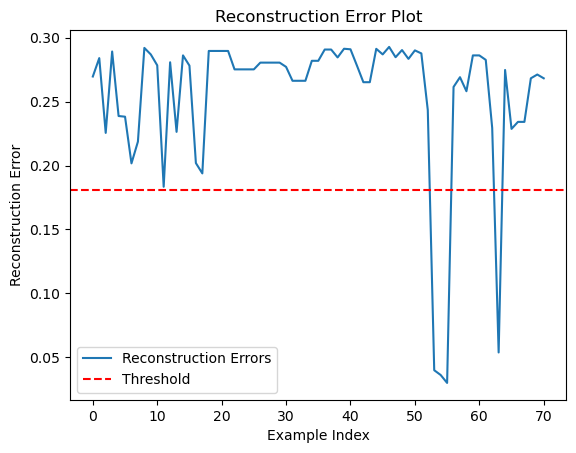

In [19]:
import matplotlib.pyplot as plt
reconstructions = model.predict( X_test_n)
reconstruction_errors = np.mean(np.square(reconstructions - X_test_n), axis=(1, 2, 3))

plt.plot(reconstruction_errors, label='Reconstruction Errors')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Example Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.title('Reconstruction Error Plot')
plt.show()


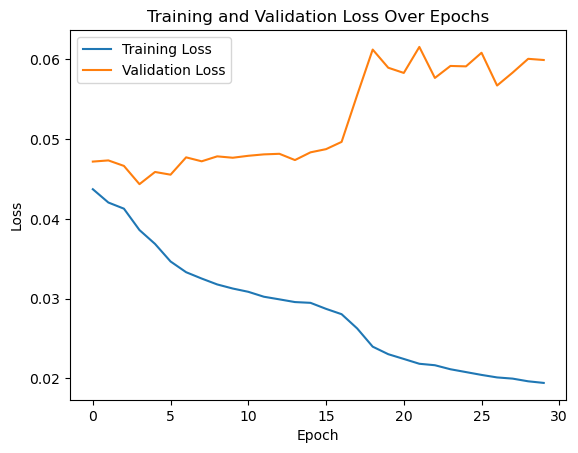

In [20]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
# Plot validation loss if applicable
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()
